# GNN4CD: temperature downscaling

In this tutorial we will use the GNN4CD model (Blasone et al.) to downscale SPHERA t2m at 3km starting from ERA5 atmospheric variables q, u, v, z at ~25km. All variables have hourly temporal resolution.

Since the training requires considerable HPC resources, we use an already trained model to perform inference. The model was trained on a period of ~15 years from 01-01-2001 to 31-11-2015 using MSE loss.

To run the notebook you can use the environment GNNenv, running the following command
`conda activate /leonardo/home/userexternal/vblasone/.conda/envs/GNNenv`

![scheme](scheme.png)

### Imports

In [33]:
import matplotlib.pyplot as plt
import matplotlib
import random
import numpy as np
import os
import torch
import pickle
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import HeteroData, Batch
import torch.nn as nn
import torch_geometric.nn as geometric_nn
from torch_geometric.nn import GATv2Conv, GraphConv
from datetime import date
import geopandas as gpd

### Utils

In [34]:
def set_seed_everything(seed):
    r"""Sets the seed for generating random numbers
    Args:
        seed (int): the desired seed
    Returns:
        None
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def standardize_input(x_low, x_high, means_low, stds_low, means_high, stds_high):

    print(f'\nStandardizing the low-res input data.')

    x_low_standard = torch.empty_like(x_low, dtype=torch.float32)
    for var in range(x_low.shape[2]):
        print(f'Done var {var}.')
        x_low_standard[:,:,var,:] = (x_low[:,:,var,:]-means_low[var]) / stds_low[var]  # num_nodes, time, vars, levels


    print(f'\nStandardizing the high-res input data')

    x_high_standard = (x_high - means_high) / stds_high
    print(f'Done.')

    return x_low_standard, x_high_standard


def date_to_idxs(year_start, month_start, day_start, year_end, month_end, day_end,
                 first_year, first_month=1, first_day=1):
    r'''
    Computes the start and end idxs crrespnding to the specified period, with respect to a
    reference date.
    Args:
        year_start (int): year at which period starts
        month_start (int): month at which period starts
        day_start (int): day at which period starts
        year_end (int): year at which period ends
        month_end (int): month at which period ends
        day_end (int): day at which period ends
        first_year (int): reference year to compute the idxs
    Returns:
        The start and end idxs for the period
    '''

    start_idx = (date(int(year_start), int(month_start), int(day_start)) - date(int(first_year), int(first_month), int(first_day))).days * 24
    end_idx = (date(int(year_end), int(month_end), int(day_end)) - date(int(first_year), int(first_month), int(first_day))).days * 24 + 24

    return start_idx, end_idx

def discrete_cmap(N, base_cmap):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = matplotlib.colormaps[base_cmap]
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

class Dataset_Graph(Dataset):
    r"""Dataset class inspired by the StaticGraphTemporalSignal class of pytorch
        geometric designed for temporal signals defined on a static graph
    """
    def __init__(self, graph, targets, **kwargs):
        self.graph = graph
        self.targets = targets
        self.additional_feature_keys = []
        for key, value in kwargs.items():
            setattr(self, key, value)
            self.additional_feature_keys.append(key)

    def __len__(self):
        return self.graph['low'].x.shape[1] # time dimension

    def _get_features(self, time_index: int):
        x_low = self.graph['low'].x[:,time_index-24:time_index+1,:]
        x_low = x_low.flatten(start_dim=2, end_dim=-1)
        return x_low

    def _get_target(self, time_index: int):
        return self.targets[:,time_index]

    def _get_train_mask(self, target: torch.tensor):
        return ~torch.isnan(target)

    def _get_additional_feature(self, time_index: int, feature_key: str):
        feature = getattr(self, feature_key)[:,time_index]
        return feature

    def _get_additional_features(self, time_index: int):
        additional_features = {
            key: self._get_additional_feature(time_index, key)
            for key in self.additional_feature_keys
        }
        return additional_features

    def set_t_offset(self, t_offset: int):
        self.t_offset = t_offset

    def __getitem__(self, time_index: int):
        x_low = self._get_features(time_index)
        y = self._get_target(time_index) if self.targets is not None else None
        train_mask = self._get_train_mask(y) if y is not None else None

        additional_features = self._get_additional_features(time_index)

        # Create the graph object
        graph = HeteroData()

        for key, value in additional_features.items():
            if value.shape[0] == self.graph['high'].x.shape[0]:
                graph['high'][key] = value
            elif value.shape[0] == self.graph['low'].x.shape[0]:
                graph['low'][key] = value

        graph['high'].y = y
        graph['high'].train_mask = train_mask
        graph.num_nodes = self.graph.num_nodes
        graph['high'].num_nodes = self.graph['high'].num_nodes
        graph['low'].num_nodes = self.graph['low'].num_nodes
        graph.t = time_index - self.t_offset

        for edge_key in self.graph.edge_types:
            if 'edge_index' in self.graph[edge_key]:  # Copy edge_index if it exists
                graph[edge_key].edge_index = self.graph[edge_key].edge_index
            if 'edge_attr' in self.graph[edge_key]:  # Copy edge_attr if it exists
                graph[edge_key].edge_attr = self.graph[edge_key].edge_attr

        graph['low'].x = x_low # low resolution input features
        graph['high'].x = self.graph['high'].x # static high resolution input features

        graph['high'].lon = self.graph['high'].lon
        graph['high'].lat = self.graph['high'].lat
        graph['low'].lon = self.graph['low'].lon
        graph['low'].lat = self.graph['low'].lat

        return graph


class Iterable_Graph(object):

    def __init__(self, dataset_graph, shuffle, idxs_vector=None, t_offset=0):
        self.dataset_graph = dataset_graph
        self.dataset_graph.set_t_offset(t_offset)
        self.shuffle = shuffle
        self.idxs_vector = idxs_vector

    def __len__(self):
        return len(self.idxs_vector)

    def __next__(self):
        if self.prog_idx < self.idxs_vector.shape[0]:
            self.idx = self.sampling_vector[self.prog_idx].item()
            self.prog_idx = self.prog_idx + 1
            return self.idx
        else:
            self.prog_idx = 0
            self.idx = 0
            raise StopIteration

    def __iter__(self):
        self.prog_idx = 0
        self.idx = 0
        if self.idxs_vector is not None:
            if self.shuffle:
                rnd_idxs = torch.randperm(self.idxs_vector.shape[0])
                self.sampling_vector = self.idxs_vector[rnd_idxs].view(self.idxs_vector.size())
            else:
                self.sampling_vector = self.idxs_vector
        else:
            if self.shuffle:
                self.sampling_vector = torch.randperm(len(self)-24) + 24 # from 24 to len
            else:
                self.sampling_vector = torch.arange(24, len(self))
        return self


def custom_collate_fn_graph(batch_list):
    return Batch.from_data_list(batch_list)


class GNN4CD_model(nn.Module):

    def __init__(self, encoding_dim=128, seq_l=25, h_in=4*5, h_hid=4*5, n_layers=2, high_in=1, low2high_out=64, high_out=64):
        super(GNN4CD_model, self).__init__()

        # input shape (N,L,Hin)
        self.rnn = nn.Sequential(
            nn.GRU(h_in, h_hid, n_layers, batch_first=True),
        )

        self.dense = nn.Sequential(
            nn.Linear(h_in*seq_l, encoding_dim),
            nn.ReLU()
        )

        self.downscaler = geometric_nn.Sequential('x, edge_index', [
            (GraphConv((encoding_dim, high_in), out_channels=low2high_out, aggr='mean'), 'x, edge_index -> x')
            ])

        self.processor = geometric_nn.Sequential('x, edge_index', [
            (geometric_nn.BatchNorm(low2high_out), 'x -> x'),
            (GATv2Conv(in_channels=low2high_out, out_channels=high_out, heads=2, dropout=0.2, aggr='mean', add_self_loops=True, bias=True), 'x, edge_index -> x'),
            (geometric_nn.BatchNorm(high_out*2), 'x -> x'),
            nn.ReLU(),
            (GATv2Conv(in_channels=high_out*2, out_channels=high_out, heads=2, dropout=0.2, aggr='mean', add_self_loops=True, bias=True),'x, edge_index -> x'),
            (geometric_nn.BatchNorm(high_out*2), 'x -> x'),
            nn.ReLU(),
            (GATv2Conv(in_channels=high_out*2, out_channels=high_out, heads=2, dropout=0.2, aggr='mean', add_self_loops=True, bias=True),'x, edge_index -> x'),
            (geometric_nn.BatchNorm(high_out*2), 'x -> x'),
            nn.ReLU(),
            (GATv2Conv(in_channels=high_out*2, out_channels=high_out, heads=2, dropout=0.2, aggr='mean', add_self_loops=True, bias=True),'x, edge_index -> x'),
            (geometric_nn.BatchNorm(high_out*2), 'x -> x'),
            nn.ReLU(),
            (GATv2Conv(in_channels=high_out*2, out_channels=high_out, heads=1, dropout=0.0, aggr='mean', add_self_loops=True, bias=True), 'x, edge_index -> x'),
            nn.ReLU(),
            ])

        self.predictor = nn.Sequential(
            nn.Linear(high_out, high_out),
            nn.ReLU(),
            nn.Linear(high_out, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
            )

    def forward(self, data, inference=False):
        encod_rnn, _ = self.rnn(data.x_dict['low']) # out, h
        encod_rnn = encod_rnn.flatten(start_dim=1)
        encod_rnn = self.dense(encod_rnn)
        encod_low2high  = self.downscaler((encod_rnn, data.x_dict['high']), data["low", "to", "high"].edge_index)
        encod_high = self.processor(encod_low2high , data.edge_index_dict[('high','within','high')])
        x_high = self.predictor(encod_high)

        if inference:
            data['high'].x_high = x_high
            data._slice_dict['high']['x_high'] = data._slice_dict['high']['y']
            data._inc_dict['high']['x_high'] = data._inc_dict['high']['y']
            data = data.to_data_list()
            x_high = [data_i['high'].x_high for data_i in data]

        return x_high

def plot_pdf(y_pred, y, range, ylim, xlabel, pred_label="predictions",
             target_label="ground truth", fontsize=16, suptitle=None):

    plt.rcParams.update({'font.size': fontsize})

    y_pred = y_pred.flatten()
    y = y.flatten()

    hist_y_pred, bin_edges_y_pred = np.histogram(y_pred, bins=np.arange(range[0],range[1],range[2]).astype(np.float32), density=False)
    hist_y, bin_edges_y = np.histogram(y, bins=np.arange(range[0],range[1],range[2]).astype(np.float32), density=False)

    Ntot_y_pred = hist_y_pred.sum()
    Ntot_y = hist_y.sum()

    bin_edges_y_pred_centre = (bin_edges_y_pred[:-1] + bin_edges_y_pred[1:]) / 2
    bin_edges_y_centre = (bin_edges_y[:-1] + bin_edges_y[1:]) / 2

    fig, ax = plt.subplots(figsize=(6,6))
    plt.fill_between(bin_edges_y_centre,hist_y/Ntot_y, color='grey', step="mid", alpha=0.25, label=target_label, zorder=2)
    ax.step(bin_edges_y_pred_centre, hist_y_pred/Ntot_y_pred, color='darkturquoise', where="mid", linewidth=1, label=pred_label, zorder=3)
    l = plt.legend(loc='upper right', facecolor='white', framealpha=1, fontsize=fontsize)
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel('frequency', fontsize=fontsize)

    if suptitle is not None:
        plt.suptitle(suptitle, y=0.95)
    plt.show()

def plot_diurnal_cycles(y_pred, y, idxs_seasons, aggr=np.nanmean, fontsize=16, figsize=(8,9),
                        xlim=[0,24], ylim=None, ylablel="[°C]", suptitle=None,
                       text_list = ['DJF', 'MAM', 'JJA', 'SON']):

    plt.rcParams.update({'font.size': fontsize})
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=figsize)

    for s in range(4):
        idxs = idxs_seasons[s]
        y_pred_s = y_pred[:,idxs]
        y_s = y[:,idxs]
        y_pred_daily_cycles = np.zeros(24)
        y_daily_cycles = np.zeros(24)
        # axi = ax[s//2, s%2]
        axi = ax[s]
        for i in range(0,24):
            y_pred_daily_cycles[i] = aggr(y_pred_s[:,i::24])
            y_daily_cycles[i] = aggr(y_s[:,i::24])
        n = 25
        vmin=min(y_pred_daily_cycles.min(), y_daily_cycles.min())
        vmax=min(y_pred_daily_cycles.max(), y_daily_cycles.max())
        axi.plot(range(1,n), y_pred_daily_cycles, label='predictions', linestyle='-', linewidth=2, color='red')
        axi.plot(range(1,n), y_daily_cycles, label='ground truth', linestyle=':', linewidth=2, color='black')
        axi.set_ylabel(ylablel, fontsize=fontsize)
        axi.set_xlabel("time [h]", fontsize=fontsize)
        axi.set_xlim(xlim)
        if ylim is not None:
            axi.set_ylim(ylim)
        else:
            axi.set_ylim([vmin-2, vmax+2])
        axi.set_xticks(ticks=range(0,n,6))
        axi.set_title(text_list[s], fontsize=fontsize+2)
        axi.grid(which='major', color='lightgrey')
    ax[0].legend(loc='upper left', prop={'size': fontsize})
    plt.tight_layout()

    if suptitle is not None:
        plt.suptitle(suptitle, y=1.1)

    plt.show()

def rmse(y, y_pred):
    return np.sqrt(np.nanmean((y - y_pred)**2, axis=1))

### Load the target, the graph file and preprocess the input data

<img src="graph.png" width="800"/>

In [35]:
path="/leonardo_scratch/large/userexternal/sdigioia/SMR4067-ICTP/north/"
target_file="target.pkl"
graph_file="graph.pkl"

train_path="/leonardo_scratch/large/userexternal/sdigioia/SMR4067-ICTP/reg_GNN4CD_scaled01_lr01_north/"
epoch="49"

In [36]:
# Load the target
with open(path+target_file, 'rb') as f:
    target = pickle.load(f)

In [37]:
# Load the Pyg graph object
with open(path+graph_file, 'rb') as f:
    graph = pickle.load(f)

# Load the input data statistics used during training
with open(train_path + "means_low.pkl", 'rb') as f:
    means_low = pickle.load(f)
with open(train_path + "stds_low.pkl", 'rb') as f:
    stds_low = pickle.load(f)
with open(train_path + "means_high.pkl", 'rb') as f:
    means_high = pickle.load(f)
with open(train_path + "stds_high.pkl", 'rb') as f:
    stds_high = pickle.load(f)

# Standardize the low-res and high-res input features
features_low, features_high = standardize_input(graph["low"].x, graph["high"].x, means_low, stds_low, means_high, stds_high)

# Update the graph initial node features with the standardized values
graph["low"].x = features_low
graph["high"].x = features_high

graph['low'].x = torch.flatten(graph['low'].x, start_dim=2, end_dim=-1)   # num_nodes, time, vars*levels


Standardizing the low-res input data.
Done var 0.
Done var 1.
Done var 2.
Done var 3.

Standardizing the high-res input data
Done.


Let's look at the Pyg HeteroData object which represents our graph!

In [38]:
graph

HeteroData(
  low={
    x=[720, 140256, 20],
    lat=[720],
    lon=[720],
    num_nodes=720
  },
  high={
    lat=[14036],
    lon=[14036],
    x=[14036, 1],
    num_nodes=14036
  },
  (high, within, high)={ edge_index=[2, 109834] },
  (low, to, high)={ edge_index=[2, 126319] }
)

### Define the test set and corresponding idxs

As test set we consider a period of 12 months not used in the training phase. We choose the period 01-12-2015 to 30-11-2016.
We start with December and finish with November because to follow the the convenction in climate science to define seasons as:

- **DJF**: December, January, February
- **MAM**: March, April, May
- **JJA**: June, July, August
- **SON**: September, October, November

In [39]:
test_year_start=2015
test_month_start=12
test_day_start=1
test_year_end=2016
test_month_end=11
test_day_end=30
first_year=2001 # This should correspond to the beginning of the data object we want to index

In [40]:
test_start_idx, test_end_idx = date_to_idxs(test_year_start, test_month_start, test_day_start, test_year_end, test_month_end, test_day_end, first_year)
if test_start_idx < 24:
    test_start_idx = 24
test_idxs = torch.tensor([*range(test_start_idx, test_end_idx)])

In [41]:
test_idxs.shape

torch.Size([8784])

Let's also determine the set of idxs for each season.

In [42]:
# create seasons
djf_start = 0 # january-february
if test_idxs.shape[0] == 8760:
    djf_end = (31*2 + 28) * 24
elif test_idxs.shape[0] == 8784:
    djf_end = (31*2 + 29) * 24
else:
    print("\nInvalid number of hours in a year: {y_pred.shape[1]}")

mam_start = djf_end
mam_end = mam_start + (31 + 30 + 31) * 24
jja_start = mam_end
jja_end = jja_start + (31 + 31 + 30) * 24
son_start = jja_end
son_end = son_start + (30 + 31 + 30) * 24

# For convenience, we group the indexis in a single list
idxs_seasons = [np.arange(djf_start, djf_end),
                np.arange(mam_start, mam_end),
                np.arange(jja_start, jja_end),
                np.arange(son_start, son_end)]

### Dataset and Dataloader

In [43]:
# Define the dataset
dataset_graph = Dataset_Graph(targets=None, graph=graph)
# Define the sampler
sampler_graph = Iterable_Graph(dataset_graph=dataset_graph, shuffle=False, idxs_vector=test_idxs)
# Define the dataloader
dataloader = DataLoader(dataset_graph, batch_size=1, num_workers=0, sampler=sampler_graph, collate_fn=custom_collate_fn_graph)

### Model

<img src="architecture.png" width="400"/>

In [44]:
model = GNN4CD_model(h_in=4*5, h_hid=4*5, high_in=1)

In [65]:
print(model)

GNN4CD_model(
  (rnn): Sequential(
    (0): GRU(20, 20, num_layers=2, batch_first=True)
  )
  (dense): Sequential(
    (0): Linear(in_features=500, out_features=128, bias=True)
    (1): ReLU()
  )
  (downscaler): Sequential(
    (0): GraphConv((128, 1), 64)
  )
  (processor): Sequential(
    (0): BatchNorm(64)
    (1): GATv2Conv(64, 64, heads=2)
    (2): BatchNorm(128)
    (3): ReLU()
    (4): GATv2Conv(128, 64, heads=2)
    (5): BatchNorm(128)
    (6): ReLU()
    (7): GATv2Conv(128, 64, heads=2)
    (8): BatchNorm(128)
    (9): ReLU()
    (10): GATv2Conv(128, 64, heads=2)
    (11): BatchNorm(128)
    (12): ReLU()
    (13): GATv2Conv(128, 64, heads=1)
    (14): ReLU()
  )
  (predictor): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [46]:
# Load the checkpoint
checkpoint = torch.load(train_path + f"checkpoint_{epoch}/pytorch_model.bin", map_location=torch.device(device))
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [47]:
model = model.to(device)
graph["low"].x = graph["low"].x.to(device)
graph["high"].x = graph["high"].x.to(device)
graph["low", "to", "high"].edge_index = graph["low", "to", "high"].edge_index.to(device)
graph["high", "within", "high"].edge_index = graph["high", "within", "high"].edge_index.to(device)

## Predictions

In [48]:
def test(model, dataloader):
    model.eval()
    step = 0

    y_pred_list = []
    times_list = []
    steps = len(dataloader)

    with torch.no_grad():
        for i, graph in enumerate(dataloader):

            t = graph.t
            times_list.append(t)

            # Regressor
            y_pred = model(graph)
            y_pred_list.append(y_pred)

            percentage = i / steps * 100
            if percentage % 10 == 0:
                print(f"{percentage:.0f}% done")
                step += 1
        print("100% done")

    y_pred_list = torch.cat(y_pred_list, dim=-1)
    times_list = torch.cat(times_list, dim=-1)

    return y_pred_list, times_list

In [49]:
predictions, times = test(model, dataloader)

0% done
50% done
100% done


In [50]:
predictions.shape

torch.Size([14036, 8784])

The target data used to train the model were scaled to [0,1] interval, thus we need to rescale back the predictions to the original range.

In [51]:
# Convert to numpy array for visualizations
predictions = predictions.cpu().numpy()

# Rescale back to the original range
min_val = 250
max_val= 350
predictions = predictions * (max_val - min_val) + min_val

# Convert to Celsius
predictions = predictions - 273.15

target_test = target[:, test_idxs]
target_test = target_test - 273.15

In [52]:
target_test = target_test.numpy()

In [53]:
predictions.min(), predictions.max(), target_test.min(), target_test.max()

(-25.89653, 36.18283, -29.34999, 36.55002)

In [54]:
shapefile_path = os.path.join("ne_10m_admin_0_countries", "ne_10m_admin_0_countries.shp")

# Load and filter for Italy
world = gpd.read_file(shapefile_path)
italy = world[world['NAME'] == 'Italy']

In [55]:
coolwarm_30 = discrete_cmap(30, 'coolwarm')

### Spatial map of average temperature

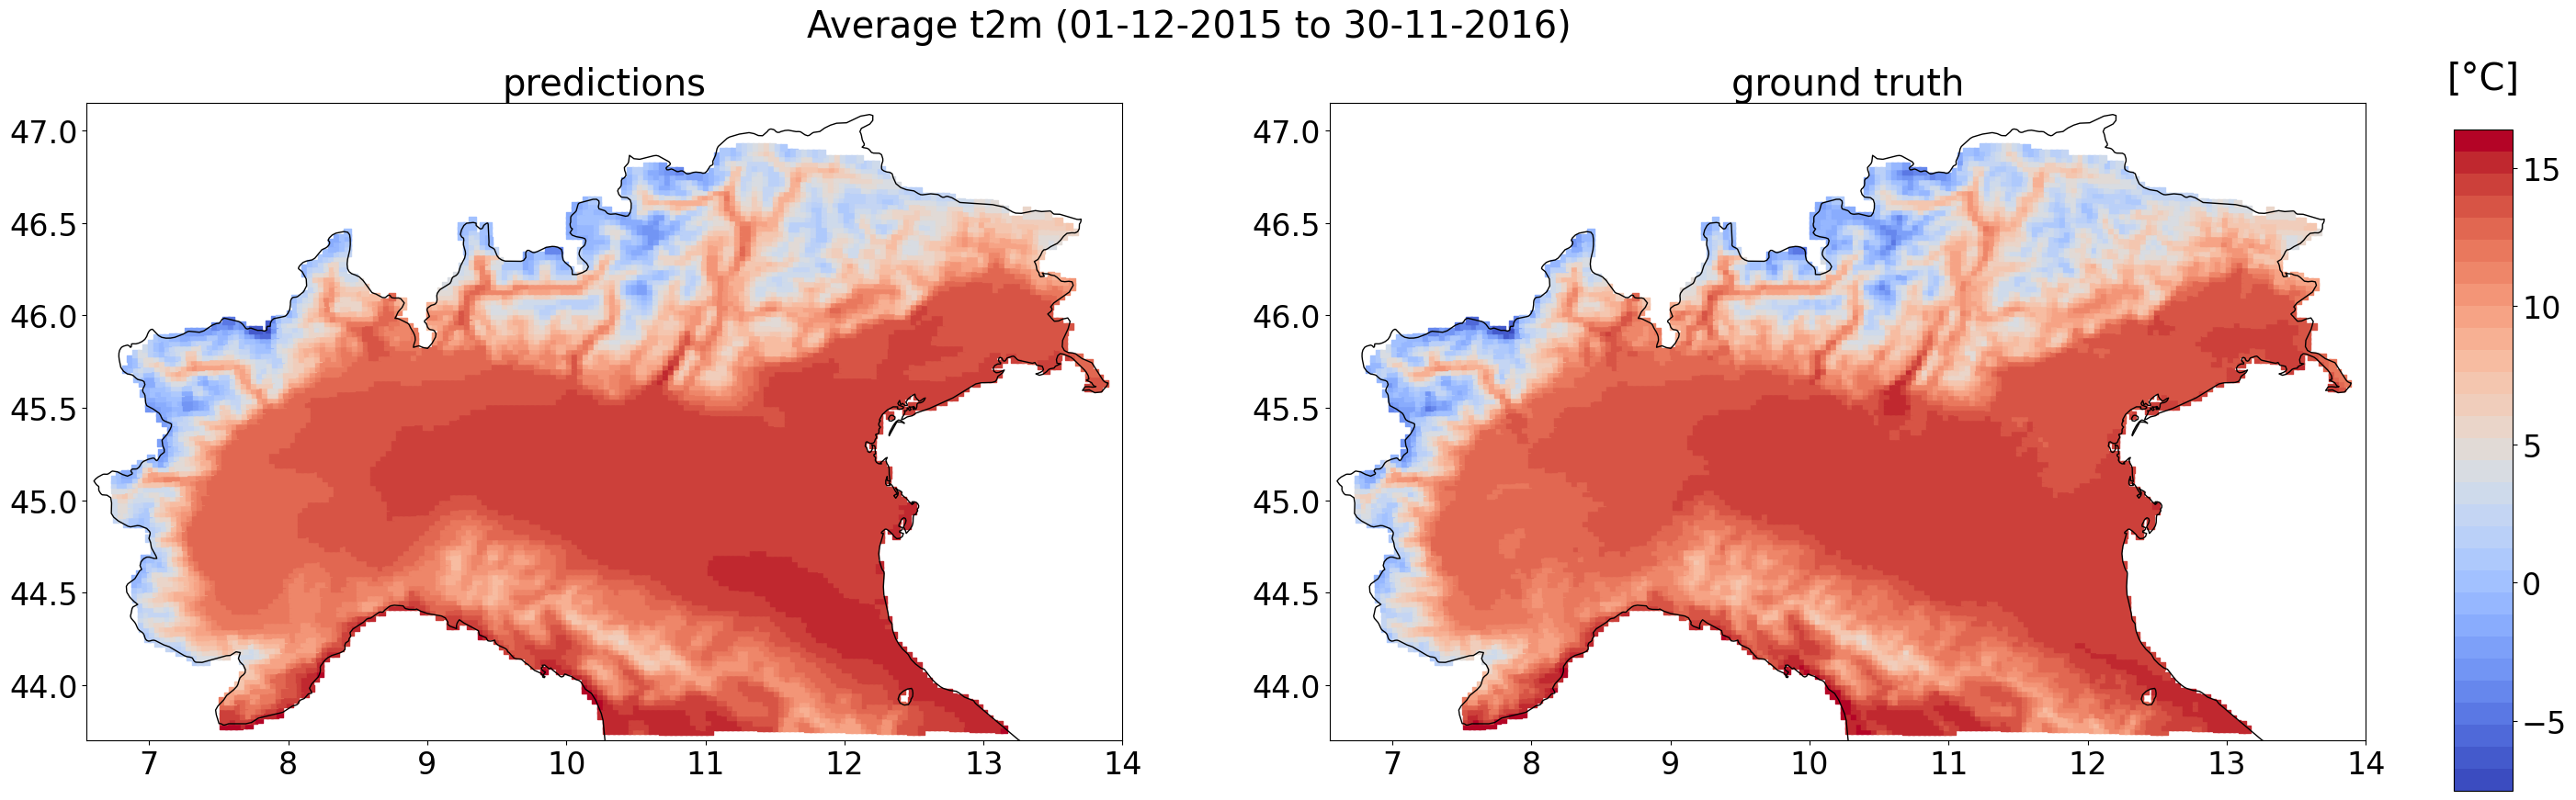

In [56]:
# Plot
xsize = 16
ysize = 12
xlim = [6.55, 14.00]
ylim = [43.70, 47.15]

matplotlib.rcParams.update({'font.size': 24})

predictions_mean = np.nanmean(predictions, axis=1)
target_mean = np.nanmean(target_test, axis=1)

vmin=min(predictions_mean.min(), target_mean.min())
vmax=max(predictions_mean.max(), target_mean.max())

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(xsize*2, ysize))

ax[0].scatter(graph["high"].lon, graph["high"].lat, c=predictions_mean, marker='s', s=30, cmap=coolwarm_30, vmin=vmin, vmax=vmax)
italy.boundary.plot(ax=ax[0], edgecolor='black', linewidth=1)
ax[0].set_title("predictions")
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)
im = ax[1].scatter(graph["high"].lon, graph["high"].lat, c=target_mean, marker='s', s=30, cmap=coolwarm_30, vmin=vmin, vmax=vmax)
italy.boundary.plot(ax=ax[1], edgecolor='black', linewidth=1)
ax[1].set_title("ground truth")
ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim)
cbar_ax = fig.add_axes([0.93, 0.16, 0.02, 0.6]) # (left, bottom, width, height) in fractions of figure width and height
cbar = fig.colorbar(im, cax=cbar_ax, aspect=25)
cbar.ax.set_title("[°C]", rotation=0, y=1.05)
plt.suptitle("Average t2m (01-12-2015 to 30-11-2016)", y=0.87)
plt.show()

### RMSE

In [57]:
YlGnBu_30 = discrete_cmap(30, 'YlGnBu')

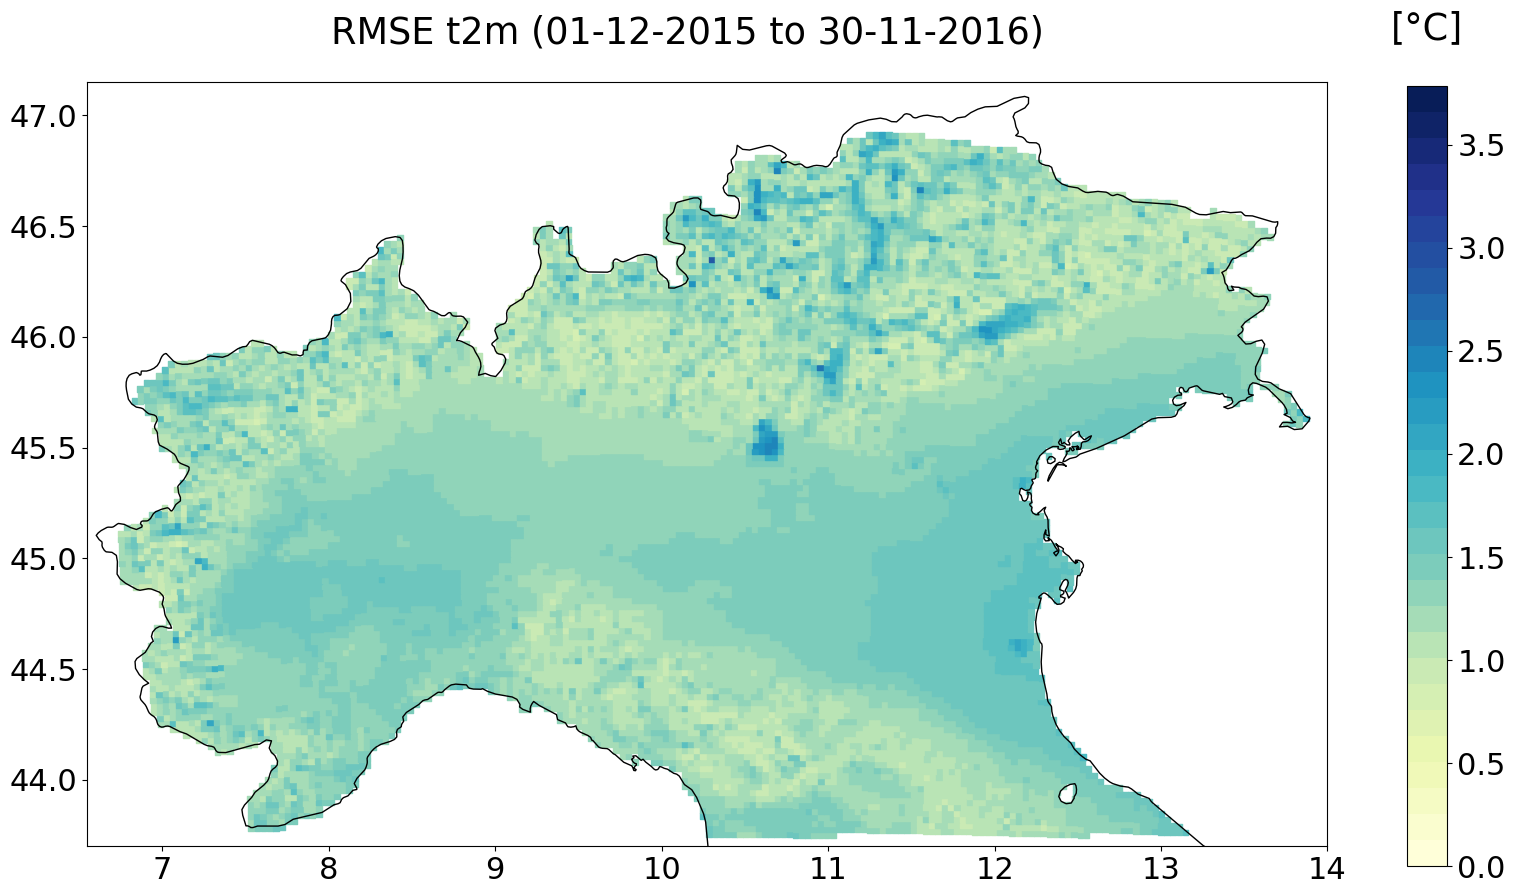

In [58]:
# Plot
xsize = 16
ysize = 12
xlim = [6.55, 14.00]
ylim = [43.70, 47.15]

matplotlib.rcParams.update({'font.size': 22})

predictions_mean = np.nanmean(predictions, axis=1)
target_mean = np.nanmean(target_test, axis=1)

t2m_rmse = rmse(predictions, target_test)

vmin=0
vmax=t2m_rmse.max() + 1

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(xsize, ysize))

im = ax.scatter(graph["high"].lon, graph["high"].lat, c=t2m_rmse, marker='s', s=16, cmap=YlGnBu_30, vmin=vmin, vmax=vmax)
italy.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

cbar_ax = fig.add_axes([0.95, 0.16, 0.025, 0.65]) # (left, bottom, width, height) in fractions of figure width and height
cbar = fig.colorbar(im, cax=cbar_ax, aspect=25)
cbar.ax.set_title("[°C]", rotation=0, y=1.05)
plt.suptitle("RMSE t2m (01-12-2015 to 30-11-2016)", y=0.87)
plt.show()

### PDF

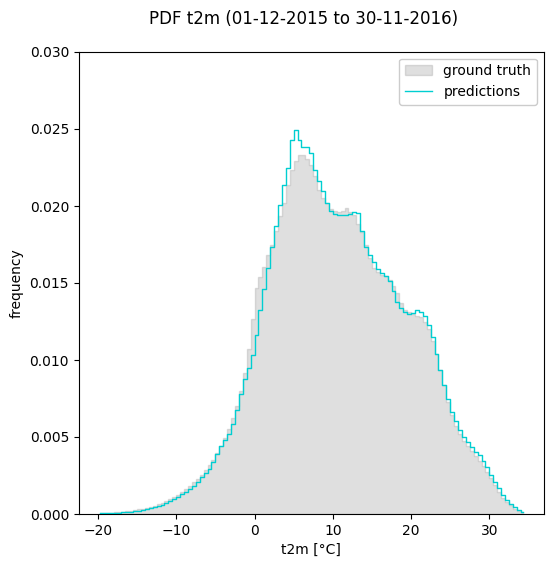

In [59]:
range_bins=[-20,35,0.5]
plot_pdf(predictions, target_test, range_bins, ylim=[0,0.03], xlabel="t2m [°C]",fontsize=10, suptitle="PDF t2m (01-12-2015 to 30-11-2016)")

## Seasonal results

### Diurnal cycles

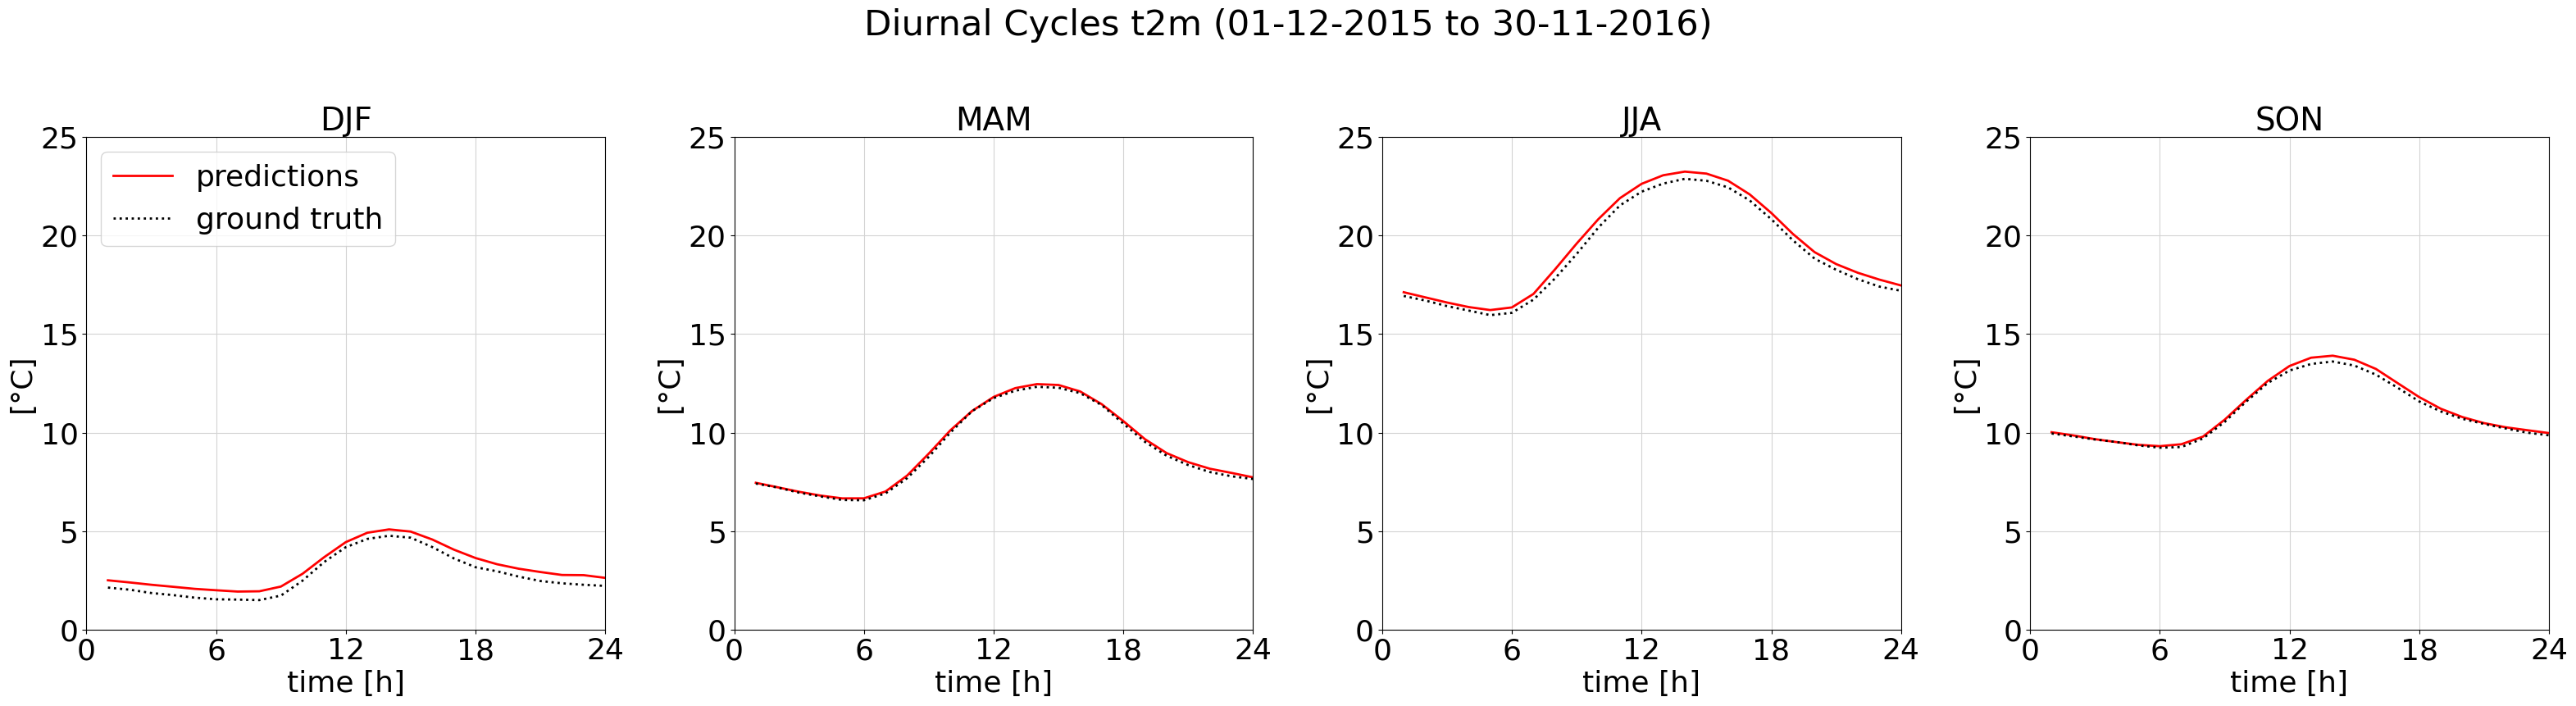

In [60]:
plot_diurnal_cycles(predictions, target_test, idxs_seasons=idxs_seasons, ylablel="[°C]", figsize=(8*4,8), fontsize=26, ylim=[0,25],
                   suptitle="Diurnal Cycles t2m (01-12-2015 to 30-11-2016)")

### RMSE

In [61]:
YlGnBu_30 = discrete_cmap(30, 'YlGnBu')

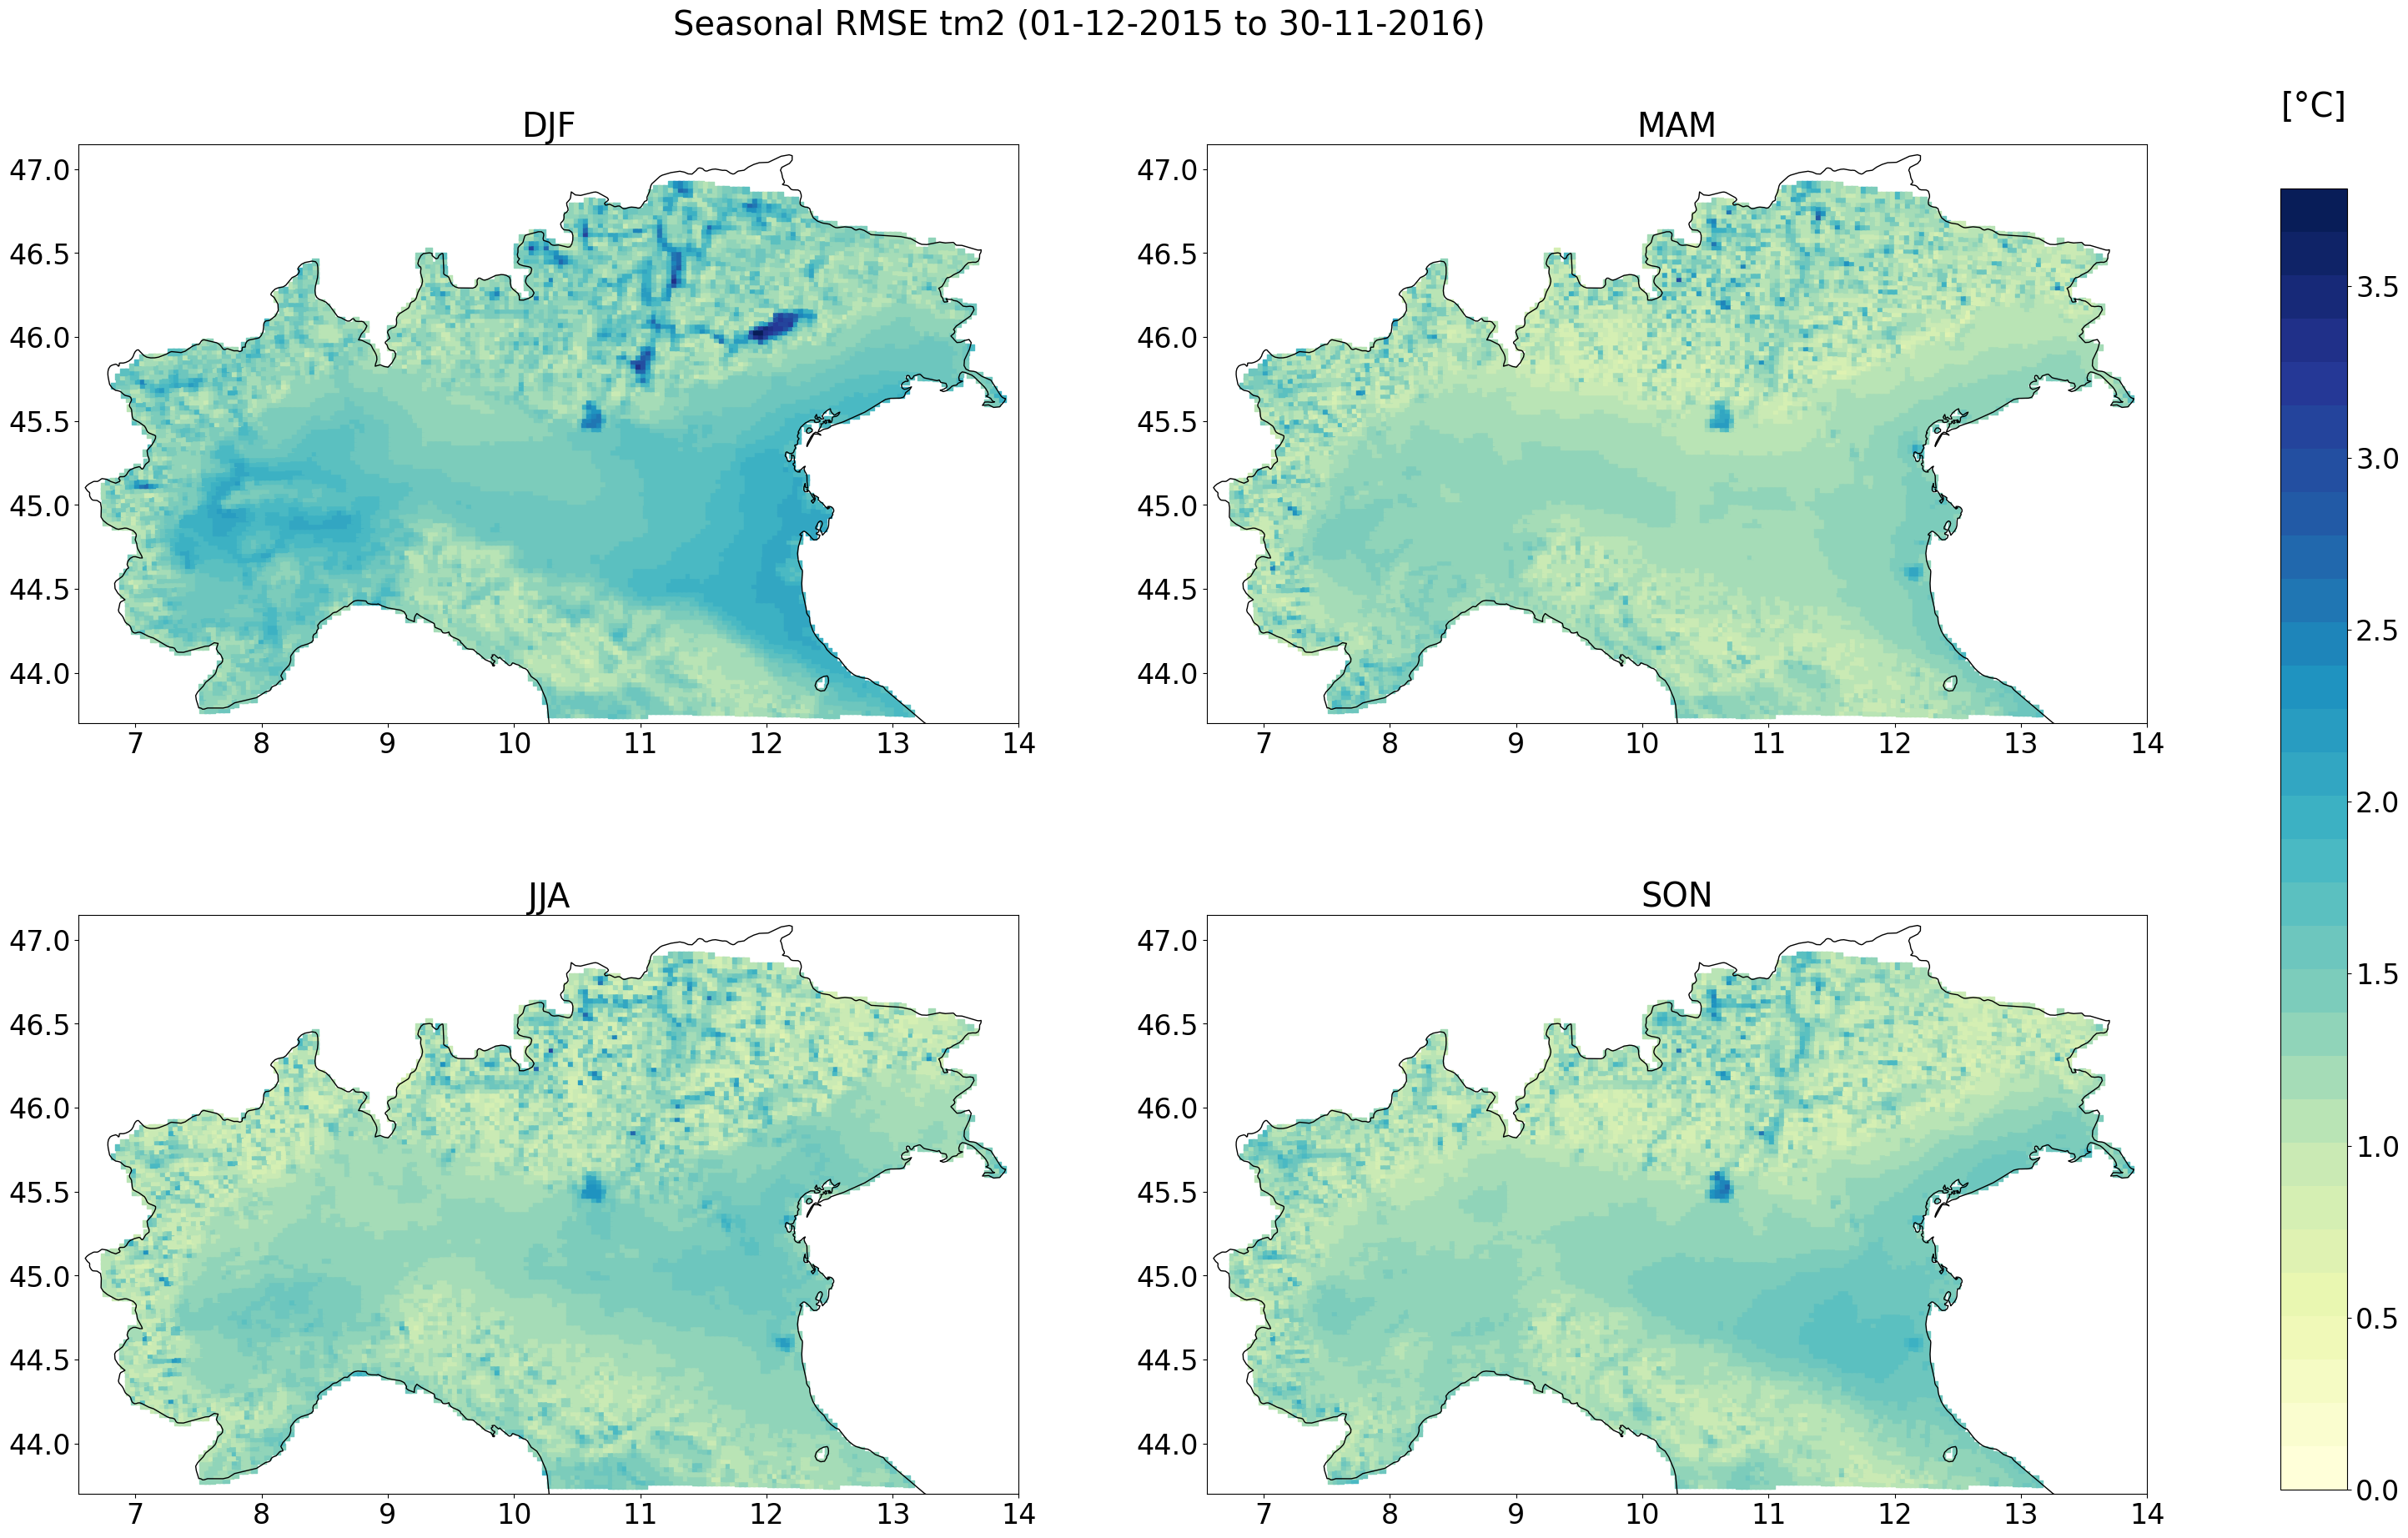

In [62]:
# Plot
xsize = 16
ysize = 12
xlim = [6.55, 14.00]
ylim = [43.70, 47.15]

matplotlib.rcParams.update({'font.size': 24})

predictions_mean = np.nanmean(predictions, axis=1)
target_mean = np.nanmean(target_test, axis=1)

t2m_rmse = rmse(predictions, target_test)

vmin=0
vmax=t2m_rmse.max() + 1

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(xsize*2, ysize*2))
text_list = ['DJF', 'MAM', 'JJA', 'SON']

for s in range(4):
    axi = ax[s//2, s%2]
    idxs_s = idxs_seasons[s]

    im = axi.scatter(graph["high"].lon, graph["high"].lat, c=rmse(predictions[:,idxs_s], target_test[:,idxs_s]),
                     marker='s', s=30, cmap=YlGnBu_30, vmin=vmin, vmax=vmax)
    italy.boundary.plot(ax=axi, edgecolor='black', linewidth=1)
    axi.set_title(text_list[s])
    axi.set_xlim(xlim)
    axi.set_ylim(ylim)

cbar_ax = fig.add_axes([0.95, 0.16, 0.025, 0.65]) # (left, bottom, width, height) in fractions of figure width and height
cbar = fig.colorbar(im, cax=cbar_ax, aspect=25)
cbar.ax.set_title("[°C]", rotation=0, y=1.05)
fig.suptitle("Seasonal RMSE tm2 (01-12-2015 to 30-11-2016)", y=0.9)
plt.subplots_adjust(hspace=0)
plt.show()